In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import print_function, absolute_import

import copy
import math
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np

from multiple_traj_opt import *
from nn_system.networks import *
from traj.vi_utils import *

from pydrake.examples.pendulum import PendulumPlant

# ALWAYS PUT TORCH INPUTS LAST!! - weird antagonistic behavior 
# if put before multiple_traj_opt.py
import torch
from torch.nn.init import *

# So that my print statements don't get weirdly interleaved!
old_print = print
def print(*args, **kwargs):
    flush = kwargs.pop('flush', False)
    old_print(*args, **kwargs)
    if flush:
        file = kwargs.get('file', sys.stdout)
        # Why might file=None? IDK, but it works for print(i, file=None)
        file.flush() if file is not None else sys.stdout.flush()
        
import functools
print = functools.partial(print, flush=True)

began iteration!
Overrode Time limit (secs) = 6.0
Overrode Time limit (secs) = 6.0
Overrode Time limit (secs) = 6.0
Overrode Time limit (secs) = 6.0
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 2.11709904671
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 2.14604592323
 0

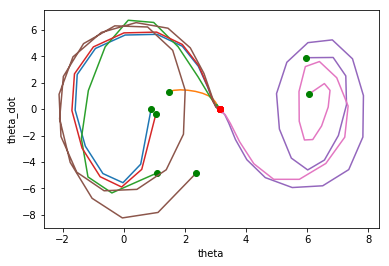

total cost:  3178.59 + ( 49557.14) | 	constraint  111.59 	bad 0,  0.00 + ( 0.00)
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 6.2018699646
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 6.2663538456
FINISHED iteration!


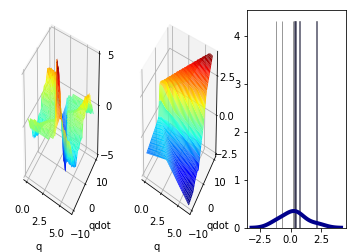

nn - vi policy deviations: avg=0.27, std=0.97, MSE=7.17, MAE=0.80


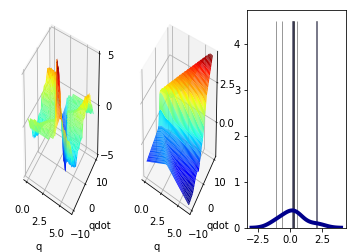

nn - vi policy deviations: avg=0.23, std=0.93, MSE=6.42, MAE=0.73
began iteration!
Overrode Time limit (secs) = 6.0
Overrode Time limit (secs) = 6.0
Overrode Time limit (secs) = 6.0
Overrode Time limit (secs) = 6.0
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 1.59459400177
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 1.5988471508
 0

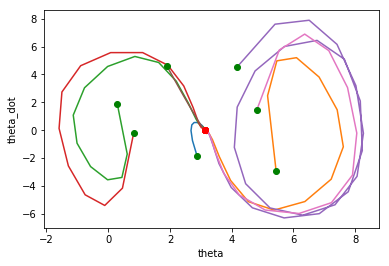

total cost:  2795.62 + ( 2001.90) | 	constraint  102.70 	bad 0,  0.00 + ( 0.00)
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 6.24567198753
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 6.37941217422
FINISHED iteration!


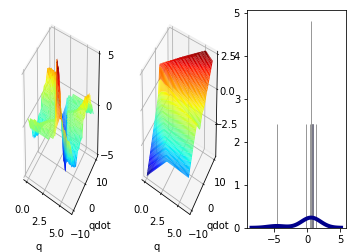

nn - vi policy deviations: avg=-0.15, std=1.86, MSE=24.50, MAE=1.22


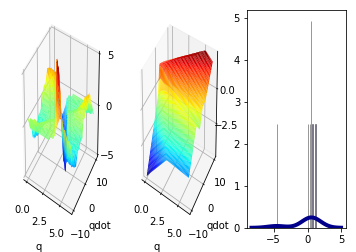

nn - vi policy deviations: avg=-0.16, std=1.83, MSE=23.60, MAE=1.14
began iteration!
Overrode Time limit (secs) = 6.0
Overrode Time limit (secs) = 6.0
Overrode Time limit (secs) = 6.0
Overrode Time limit (secs) = 6.0
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 3.06852793694
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 3.07815790176
 0

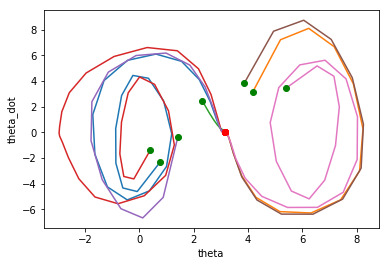

total cost:  2558.61 + ( 619.24) | 	constraint  98.60 	bad 0,  0.00 + ( 0.00)
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 6.22508597374
RESULT: SolutionResult.kUnknownError TOTAL ELAPSED TIME: 6.35118103027
FINISHED iteration!


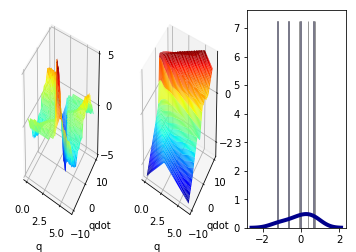

nn - vi policy deviations: avg=-0.03, std=0.66, MSE=3.06, MAE=0.54


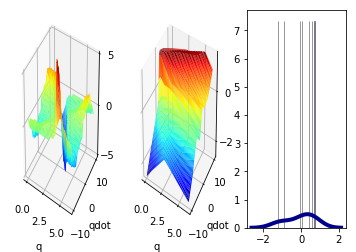

nn - vi policy deviations: avg=-0.06, std=0.69, MSE=3.36, MAE=0.56
began iteration!
Overrode Time limit (secs) = 6.0
Overrode Time limit (secs) = 6.0
Overrode Time limit (secs) = 6.0
Overrode Time limit (secs) = 6.0


In [ ]:
##### RUSS'S MINIBATCH METHOD
import sys
seed = 1776; np.random.seed(seed); torch.manual_seed(seed)

use_dropout = True
nn_init     = kaiming_uniform_ # Will this even do anything with warm starting?
nn_noise    = 1e-2
class FCBIG(nn.Module):
    def __init__(self, n_inputs=4, h_sz=32, nn_init=None, nn_noise=0., use_dropout=False):
        self.nn_noise = nn_noise
        self.use_dropout = use_dropout
        super(FCBIG, self).__init__()
        self.n_inputs = n_inputs
        self.fc1 = nn.Linear(self.n_inputs, h_sz)
        self.fc2 = nn.Linear(h_sz, 1)
        
        if use_dropout:
            self.dropout = nn.Dropout(0.5) 
        
        if nn_init is not None:
            nn_init(self.fc1.weight)
            nn_init(self.fc2.weight)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        if self.use_dropout:
            x = self.dropout(x)
        x = self.fc2(x)
        x += self.nn_noise # Will this work in Torch?
        return x
    

total_iterations = 10

vi_policy, _ = load_policy("good", "pendulum")

########################################
# MACHINERY FOR PARALLELISM

def parallel_helper(inp):
    (method, packed_mto, ic_list, kwargs) = inp
    mto = unpack_mto(*packed_mto)
    
#     print("{} doing method".format(kwargs["i"]))
    old_mto, new_mto = method(mto, ic_list, **kwargs)
#     print("{} FINISHED method".format(kwargs["i"]))
    
    packed_old_mto = pack_mto(old_mto)
    packed_new_mto = pack_mto(new_mto)

    return packed_old_mto, packed_new_mto

N = 2
def do_parallel(method, mtos, ic_lists, **kwargs):
    from pathos.multiprocessing import ProcessingPool as Pool
#     from multiprocessing import Pool
    p = Pool(N)
    inputs = []
    for i, (mto, ic_list) in enumerate(zip(mtos, ic_lists)):
        kwargs_copy = copy.deepcopy(kwargs)
        
        # Disable all but the first visualization stream when running parallel
        kwargs_copy['i'] = i
        if i != 0: 
            kwargs_copy["vis_cb_every_nth"] = None
            kwargs_copy["cost_cb_every_nth"] = None
            
        # Pack the mto so it doesn't give pickle/copy complaints
        packed_mto = pack_mto(mto)
        inputs.append((method, packed_mto, ic_list, kwargs_copy))

    results = p.map(parallel_helper, inputs)

    results = [(unpack_mto(*packed_old_mto), unpack_mto(*packed_new_mto) )
                    for (packed_old_mto, packed_new_mto) in results]
    old_mtos, new_mtos = zip(*results)
    return old_mtos, new_mtos

def kNetConstructor():
    return FCBIG(n_inputs=2, nn_init=nn_init)

# N = multiprocessing.cpu_count() - 2
old_mtos = [None]*N
new_mtos = [None]*N
while total_iterations > 0:
    total_iterations -= 1
    num_trajectories = 7
    ic_list = initial_conditions_random(num_trajectories, (0, 2*math.pi), (-5, 5))
#     old_mtos[0], new_mtos[0] = method4(new_mtos[0], ic_list,
    print("began iteration!")
    old_mtos, new_mtos = do_parallel(method4, new_mtos, [ic_list]*N, 
                              num_trajectories=num_trajectories,
                              expmt = "pendulum",
                              kNetConstructor=kNetConstructor,
                              use_constraint=False,
                              cost_factor=25.,
                              vis_cb_every_nth=50, 
                              cost_cb_every_nth=50, 
                              seed=None,
                              snopt_overrides=[('Time limit (secs)',  6.0)])
    print("FINISHED iteration!")
#     print("After iteration params: ", new_mtos[0].prog.GetInitialGuess(new_mtos[0].T))

    def vis_old_new_mto_pair(old_mto, new_mto):
        # Print learned policy vs vi_policy here (only possible for state dim == 2)
        net = new_mto.create_net(from_initial_guess=(N>1)) # b/c of our weird ass pickling HACK
        net.eval()
        fig = plt.figure()
        ax1 = fig.add_subplot(131, projection='3d')
        ax2 = fig.add_subplot(132, projection='3d')
        ax3 = fig.add_subplot(133)
        if new_mto.expmt == "pendulum":
            vis_vi_policy(vi_policy, ax1)
            vis_nn_policy_like_vi_policy(net, vi_policy, ax2)

        # Print Divergence metrics between the two policies
        results = []
        if new_mto.expmt == "pendulum":
            test_coords = initial_conditions_random(num_trajectories, (0, 2*math.pi), (-5/2, 5/2))
        elif new_mto.expmt == "cartpole":
            test_coords = initial_conditions_random_all_dims(num_trajectories, ((-3., 3.), (0., 2*math.pi), (-1., 1.), (-1., 1.)) )
        test_coords = ic_list
        for coord in test_coords:
            pair = (eval_vi_policy(coord, vi_policy), eval_nn_policy(coord, net))
            results.append(pair)
        diffs = [result[1] - result[0] for result in results]
        plot_and_print_statistics(diffs, "nn - vi policy deviations", bins=100, xlim=None, ax=ax3)
    
    DISPLAY_ALL = True
    print("\nBEFORE NN MERGE")
    for i, (old_mto, new_mto) in enumerate(zip(old_mtos, new_mtos)):
        if i == 0 or DISPLAY_ALL:
            vis_old_new_mto_pair(old_mto, new_mto)

    # Do NN Merge here!
    
    
    print("\AFTER NN MERGE")
    for i, (old_mto, new_mto) in enumerate(zip(old_mtos, new_mtos)):
        if i == 0 or DISPLAY_ALL:
            vis_old_new_mto_pair(old_mto, new_mto)

        

## ----------------------------------------- Visualizations below this line --------------------------------------

In [ ]:
#### Get a sense of the consistency of x and u!
# Let's plot all the u's on the z axis and x (theta, theta_dot) on the y and x axes...
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs, ys, zs = [], [], []
for ti in range(new_mto.num_trajectories):
    h_sol  = new_mto.prog.GetSolution(new_mto.h[ti])[0]
    print(h_sol)

    t_s = [h_sol*i for i in range(new_mto.num_samples)]
    x_s  = new_mto.prog.GetSolution(new_mto.x[ti])
    u_s    = new_mto.prog.GetSolution(new_mto.u[ti])
    x_trajectory = PiecewisePolynomial.Cubic(t_s, x_s, False)
#     t_samples = np.linspace(breaks[0], breaks[-1], 100) 
#     x_samples = np.hstack([x_trajectory.value(t) for t in t_samples])
    thetas, theta_dots = zip(*x_s)
    print(thetas, theta_dots, u_s)
    xs += thetas
    ys += theta_dots
    zs += u_s
print(list((len(thing) for thing in (xs, ys, zs))))
ax.scatter(xs, ys, zs, c='b', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

<IPython.core.display.Javascript object>


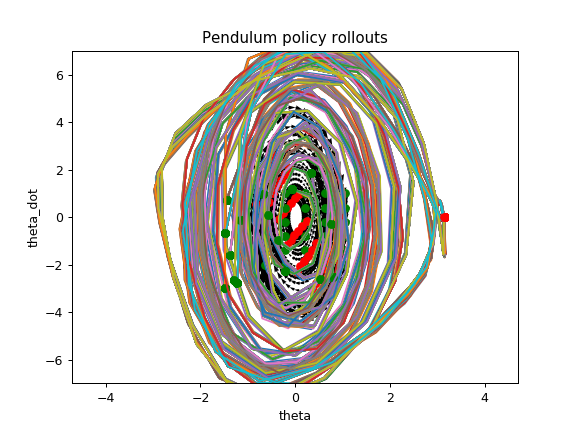

In [28]:
import math
ic_list = initial_conditions_grid(36, (-math.pi/3, math.pi/3), (-5/3, 5/3))
new_mto.plot_all_policies("state_quiver", ic_list)

In [ ]:
from nn_system.NNSystemHelper import create_nn
kNetConstructor = lambda: FCBIG(2)
nn = create_nn(kNetConstructor, list(new_mto.prog.GetSolution(new_mto.T)))
list(nn.parameters())

In [ ]:
ti = 0
mto.render_policy(ti)

<IPython.core.display.Javascript object>


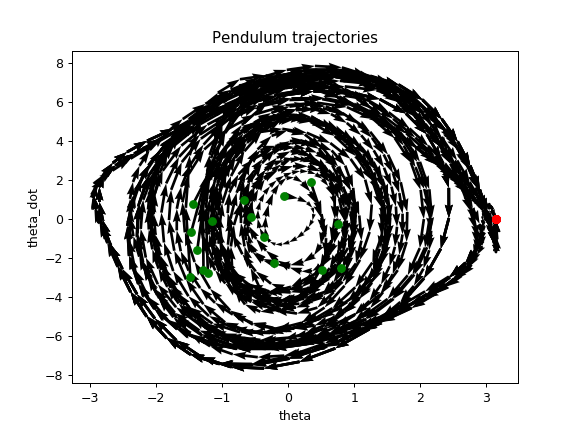

In [27]:
# mto.plot_all_trajectories("state_scatter")
new_mto.plot_all_trajectories("state_quiver")
# mto.plot_all_trajectories("tip_scatter")
# mto.plot_all_trajectories("tip_quiver")

### Visualize the found trajectories

In [ ]:
ti = 0
mto.plot_single_trajectory(ti, "state_scatter")
mto.plot_single_trajectory(ti, "state_quiver")
mto.plot_single_trajectory(ti, "tip_scatter")
mto.plot_single_trajectory(ti, "tip_quiver")

mto.render_single_trajectory(ti)